In [7]:
import requests
import re
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
from IPython.display import display, clear_output

In [8]:
def make_clickable(val):
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

In [9]:
r = requests.get('https://prow.ci.openshift.org/prowjobs.js?omit=annotations,decoration_config,pod_spec')

In [10]:
results = r.json()

In [11]:
def plot_test_results(platform):
    clear_output(wait=True)
    jobresults = {}
    #platforms = ['vsphere', 'azure', 'arm']

    for item in results['items']:
        #if any(x in item['spec']['job'] for x in platforms):
        if platform in item['spec']['job']:
            if 'periodic' in item['metadata']['labels']['prow.k8s.io/type']:
                try:      
                    version = re.search(r'(\d\.\d*)', item['metadata']['labels']['ci-operator.openshift.io/variant']).group(1)

                    if version not in jobresults:
                        jobresults[version] = {}
                        jobresults[version]['failure'] = 0
                        jobresults[version]['success'] = 0
                        jobresults[version]['urls'] = []

                    if not any(x in item['status']['state'] for x in ['success', 'pending']):
                        jobresults[version]['failure'] += 1
                        jobresults[version]['urls'].append(item['status']['url'])
                    else:
                        jobresults[version]['success'] += 1 
                except:
                    pass
                
    
    
    plotdata = pd.DataFrame.from_dict(jobresults, orient='index')
    df = plotdata.explode('urls')
    bar = plotdata.plot(kind="bar", title="Periodics: {}".format(platform))
    
    s = df.style.format({'urls': make_clickable}).hide_columns(["failure","success"])
    
    
    display(s)
    display(bar)
    sys.stdout.flush()

interactive(children=(Select(description='platform', options=('vsphere', 'azure', 'arm'), value='vsphere'), Ou…

<function __main__.plot_test_results(platform)>

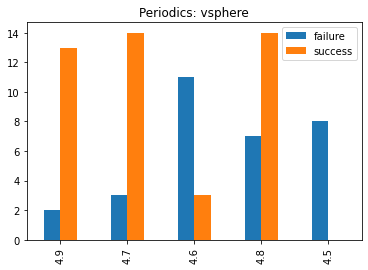

In [12]:
interact(plot_test_results, platform=widgets.Select(options=["vsphere","azure","arm"]))